In [19]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import torch
from transformers import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

STIMULUS = "21st_year"
MODEL = 'bert-base-uncased'

foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for TR-aligned tokens in data/stimuli/21st_year/tr_tokens.csv
Loaded 2225 TRs.


# Attention Analyses

In [20]:
foo.process_stimulus_attentions()
foo.process_stimulus_activations()

Processed 2225 TRs for activations.


In [21]:
foo.mask_non_tr_attentions()

In [22]:
foo.compute_attention_head_magnitudes(p=1)
foo.compute_attention_head_magnitudes(p=2)
foo.compute_attention_head_magnitudes(p='inf')

In [23]:
import itertools

p='inf'

def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

attention_vectors = foo.stimulus_df["attention_heads_L{}".format(p)].apply(lambda x: flatten(x))
foo.stimulus_df["attention_heads_L{}_vector".format(p)] = attention_vectors

for_output = foo.stimulus_df[["attention_heads_L{}_vector".format(p)]]

In [24]:
for_output.to_pickle("{}_{}_attention_heads_L-{}.pkl".format(STIMULUS, MODEL, p))

In [25]:
baz = pd.read_pickle("{}_{}_attention_heads_L-{}.pkl".format(STIMULUS, MODEL, p))
baz.head(10)

,attention_heads_Linf_vector
0,None
1,None
2,"[0.1127467155456543, 0.2125963419675827, 0.666..."
3,"[0.27988120913505554, 0.37977686524391174, 0.8..."
4,"[0.13208642601966858, 0.18866196274757385, 0.6..."
5,"[0.20532341301441193, 0.1709577590227127, 0.40..."
6,"[0.1420295238494873, 0.18466304242610931, 0.67..."
7,"[0.16158738732337952, 0.2766321003437042, 0.74..."
8,"[0.15055854618549347, 0.2811071276664734, 0.86..."
9,"[0.12693165242671967, 0.269744336605072, 0.951..."


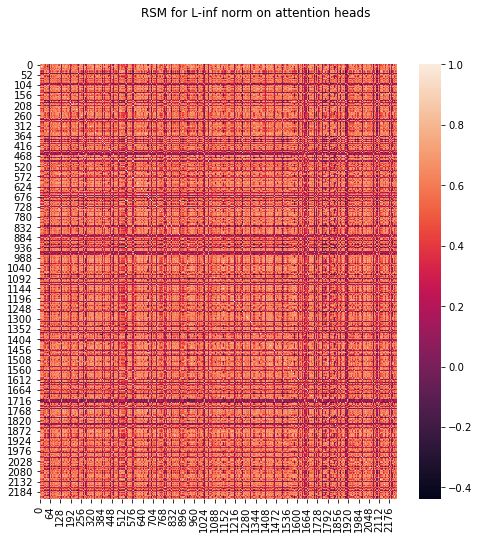

In [26]:
non_null = for_output[~pd.isnull(for_output["attention_heads_L{}_vector".format(p)])]

non_null_df = pd.DataFrame.from_records(non_null["attention_heads_L{}_vector".format(p)].values)

rsm_df = pd.DataFrame(np.corrcoef(non_null_df))

plt.figure(figsize=(8,8))
sns.heatmap(rsm_df)
plt.suptitle("RSM for L-inf norm on attention heads");

# "Attention Effects"

### End-to-end
How far do tokens "move in space" from the initial embeddings to final outputs?

`activation_end_to_end_l2_distances[n_token]` gives the start-to-finish displacement of the contextualization process. Longer distances indicates the token's meaning was changed more during contextualization.

In [27]:
foo.end_to_end_token_movement()

def normalize_col(col):
    
    de_meaned = col - col.mean()
    return de_meaned / de_meaned.std()

foo.stimulus_df["activation_end_to_end_mean_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.mean(x))
foo.stimulus_df["activation_end_to_end_max_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.max(x))

foo.stimulus_df.activation_end_to_end_mean_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_mean_l2)
foo.stimulus_df.activation_end_to_end_max_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_max_l2)

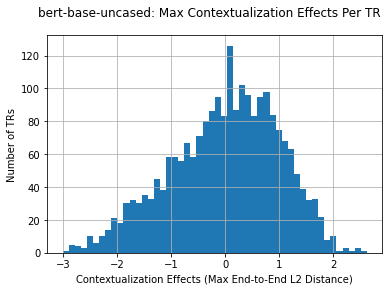

In [28]:
foo.stimulus_df.activation_end_to_end_max_l2.hist(bins=50)
plt.suptitle("{}: Max Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Max End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

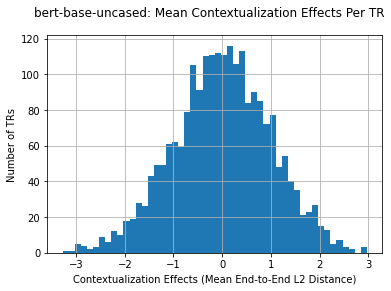

In [29]:
foo.stimulus_df.activation_end_to_end_mean_l2.hist(bins=50)
plt.suptitle("{}: Mean Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Mean End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

### Layerwise
How far do tokens move each layer?

`activation_layerwise_l2_distances[n_layer][n_token]` gives the L2 distance that each token moved, each layer.

We can look at the mean or max distance for each layer + token.

In [30]:
foo.layerwise_token_movement()

len(foo.stimulus_df["activation_layerwise_l2_distances"][0][0])

5

In [31]:
mean_l2_per_layer = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.mean(layer) for layer in x])
max_l2_per_layer = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.max(layer) for layer in x])

foo.stimulus_df["activation_layerwise_mean_l2"] = mean_l2_per_layer
foo.stimulus_df["activation_layerwise_max_l2"] = max_l2_per_layer

['what', ',', '25', '?', '26', '?']


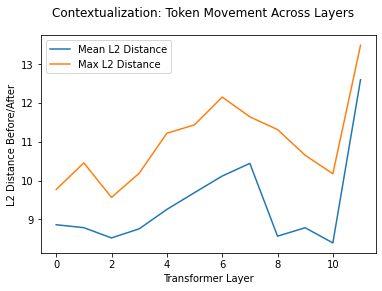

In [32]:
test = foo.stimulus_df.iloc[202]
print(test.transformer_tokens_in_tr)

plt.plot(test["activation_layerwise_mean_l2"], label="Mean L2 Distance")
plt.plot(test["activation_layerwise_max_l2"], label="Max L2 Distance")
plt.xlabel("Transformer Layer")
plt.ylabel("L2 Distance Before/After")
plt.legend(loc='best')
plt.suptitle("Contextualization: Token Movement Across Layers");

In [33]:
print("Mean / Std of Max L2 Displacement Across Layers: {}, {}".format(STIMULUS, MODEL))
df = pd.DataFrame.from_records(foo.stimulus_df.activation_layerwise_max_l2)
df.apply([np.mean, np.std])

Mean / Std of Max L2 Displacement Across Layers: 21st_year, bert-base-uncased


,0,1,2,3,4,5,6,7,8,9,10,11
mean,10.508816,10.142597,9.739985,9.415208,9.424703,9.861313,11.432344,10.188130,10.262768,10.137424,9.158351,13.118155
std,1.380315,1.583332,1.971785,1.547923,1.429370,1.484121,1.012290,1.091303,1.190737,1.331970,1.394525,2.656952


In [34]:
normalized = (df-df.mean())/df.std()
normalized.apply([np.mean, np.std])
foo.stimulus_df["activation_layerwise_max_l2_normed"] = [list(r) for r in normalized.to_records(index=False)]

In [35]:
attention_effects_df = foo.stimulus_df[['activation_end_to_end_max_l2', 'activation_layerwise_max_l2_normed']]
attention_effects_df.to_pickle("{}_{}_attention_effects_max_l2.pkl".format(STIMULUS, MODEL, p))

<AxesSubplot:>

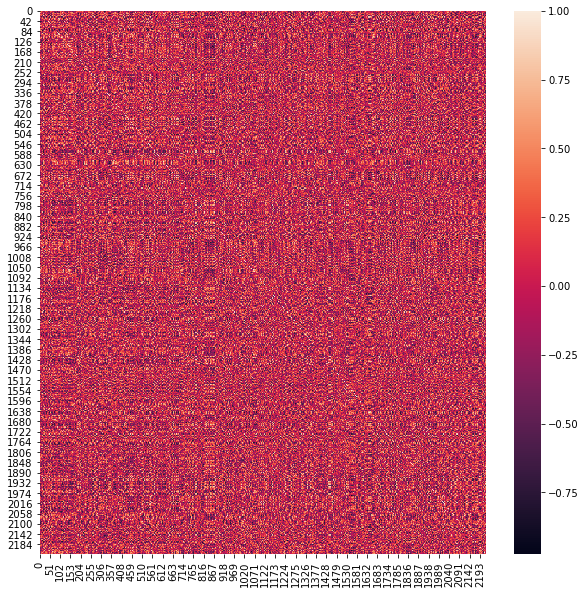

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(np.corrcoef(normalized)))